In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

train = train[ train['Stance'] != 'unrelated' ]
test = test[ test['Stance'] != 'unrelated' ]
print(train.shape)
print(test.shape)

(10724, 4)
(2703, 4)


In [3]:
def review_to_words(raw_review, remove_stopwords=False):
    #Convert the raw review string to a cleaner version taking the steps below
    #Why? So that sklearn's CountVectorizer will accept the review data as input
    
    #remove HTML
    review_text = bs(raw_review, "html.parser").get_text()
    
    #remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    #convert to lowercase and split into individual words
    words = letters_only.lower().split() 
    
    if remove_stopwords:
        #convert stopwords to a set
        stops = set(stopwords.words("english"))  
    
        #remove stop words
        words = [w for w in words if not w in stops]
    
    #join words back together
    #(this is just a long string of the words in the review)
    return words

In [4]:
# import word2vec so we can build our model
from gensim.models import word2vec
from gensim.models import KeyedVectors
# load nltk
import nltk.data
# load the tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

c:\users\jake\anaconda3\envs\nnets\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# Define a function to split a review into parsed sentences
def text_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_words( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [6]:
headline_len = 50
article_len = 200
dim = headline_len+article_len

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 256   # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = -1       # Number of threads to run in parallel
context = 5           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


In [8]:
# prepare data for input to Word2Vec
sentences = []

print('Parsing sentences from training set')
for i,row in train.iterrows():
    headline = row['Headline']
    articleBody = row['articleBody']
    
    headline = text_to_sentences(headline, tokenizer, False)
    articleBody = text_to_sentences(articleBody, tokenizer, False)

    combined = headline + articleBody
    sentences += combined


for i,row in test.iterrows():
    headline = row['Headline']
    articleBody = row['articleBody']
    
    headline = text_to_sentences(headline, tokenizer, True)
    articleBody = text_to_sentences(articleBody, tokenizer, True)

    combined = headline + articleBody
    sentences += combined
    

Parsing sentences from training set


c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [9]:
print(len(sentences))
print(sentences[0])

238514
['it', 'begins', 'hazmat', 'wearing', 'passenger', 'spotted', 'at', 'airport']


In [10]:
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

2017-04-24 17:30:04,399 : INFO : collecting all words and their counts
2017-04-24 17:30:04,399 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-24 17:30:04,441 : INFO : PROGRESS: at sentence #10000, processed 225169 words, keeping 10340 word types
2017-04-24 17:30:04,473 : INFO : PROGRESS: at sentence #20000, processed 447736 words, keeping 12863 word types
2017-04-24 17:30:04,505 : INFO : PROGRESS: at sentence #30000, processed 676463 words, keeping 14036 word types


Training model...


2017-04-24 17:30:04,535 : INFO : PROGRESS: at sentence #40000, processed 892427 words, keeping 14992 word types
2017-04-24 17:30:04,566 : INFO : PROGRESS: at sentence #50000, processed 1112501 words, keeping 15686 word types
2017-04-24 17:30:04,596 : INFO : PROGRESS: at sentence #60000, processed 1330515 words, keeping 16458 word types
2017-04-24 17:30:04,625 : INFO : PROGRESS: at sentence #70000, processed 1561268 words, keeping 17199 word types
2017-04-24 17:30:04,657 : INFO : PROGRESS: at sentence #80000, processed 1787971 words, keeping 17842 word types
2017-04-24 17:30:04,686 : INFO : PROGRESS: at sentence #90000, processed 2013399 words, keeping 18356 word types
2017-04-24 17:30:04,717 : INFO : PROGRESS: at sentence #100000, processed 2225637 words, keeping 18948 word types
2017-04-24 17:30:04,745 : INFO : PROGRESS: at sentence #110000, processed 2449189 words, keeping 19388 word types
2017-04-24 17:30:04,778 : INFO : PROGRESS: at sentence #120000, processed 2678543 words, keepin

In [11]:
model.init_sims(replace=True)

2017-04-24 17:30:05,832 : INFO : precomputing L2-norms of word weight vectors


In [12]:
train_X_tensor = np.zeros((len(train.index),headline_len+article_len,256))
print('Converting training pairs to w2v')
for i,row in train.iterrows():
    headline = row['Headline']
    articleBody = row['articleBody']
    
    headline = text_to_sentences(headline, tokenizer, False)
    articleBody = text_to_sentences(articleBody, tokenizer, False)
    
    headline_w2v = np.zeros((headline_len,256))
    i = 0
    for sent in headline:
        if len(sent) == 0:
            continue
        sent_w2v = model.wv[sent]
        for vec in sent_w2v:
            if i >= headline_len:
                break
            headline_w2v[i,:] = vec
            i += 1
        if i >= headline_len:
            break
    
    article_w2v = np.zeros((article_len-1,256))
    i=0
    for sent in articleBody:
        if len(sent) == 0:
            continue
        sent_w2v = model.wv[sent]
        for vec in sent_w2v:
            if i >= article_len-1:
                break
            article_w2v[i,:] = vec
            i += 1
        if i >= article_len-1:
            break
            
    divider = np.array([-99]*256).reshape(1,256)
    
    headline_w2v = np.append(headline_w2v,divider, axis=0)
    combined = np.append(headline_w2v,article_w2v, axis=0)
    
    train_X_tensor[i,:,:] = combined

Converting training pairs to w2v


c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [13]:
print(train_X_tensor.shape)

(10724, 250, 256)


In [14]:
test_X_tensor = np.zeros((len(test.index),headline_len+article_len,256))
print('Converting test pairs to w2v')
for i,row in test.iterrows():
    headline = row['Headline']
    articleBody = row['articleBody']
    
    headline = text_to_sentences(headline, tokenizer, False)
    articleBody = text_to_sentences(articleBody, tokenizer, False)
    
    headline_w2v = np.zeros((headline_len,256))
    i = 0
    for sent in headline:
        if len(sent) == 0:
            continue
        sent_w2v = model.wv[sent]
        for vec in sent_w2v:
            if i >= headline_len:
                break
            headline_w2v[i,:] = vec
            i += 1
        if i >= headline_len:
            break
    
    article_w2v = np.zeros((article_len-1,256))
    i=0
    for sent in articleBody:
        if len(sent) == 0:
            continue
        sent_w2v = model.wv[sent]
        for vec in sent_w2v:
            if i >= article_len-1:
                break
            article_w2v[i,:] = vec
            i += 1
        if i >= article_len-1:
            break
            
    divider = np.array([-99]*256).reshape(1,256)
    
    headline_w2v = np.append(headline_w2v,divider, axis=0)
    combined = np.append(headline_w2v,article_w2v, axis=0)
    
    test_X_tensor[i,:,:] = combined

Converting test pairs to w2v


c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
c:\users\jake\anaconda3\envs\nnets\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [15]:
def make_response(stance):
    
    response = [0,0,0]
    if stance == 'agree':
        response[0] = 1
    elif stance == 'disagree':
        response[1] = 1
    elif stance == 'disagree':
        response[2] = 1
    
    return response

In [16]:
y_train = train['Stance'].apply(make_response)
y_train = np.matrix(y_train.tolist())
y_test = test['Stance'].apply(make_response)
y_test = np.matrix(y_test.tolist())

In [17]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Conv1D, Flatten
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


In [18]:
vocab_size=1000

In [26]:
MLP_input = Input(shape=train_X_tensor.shape[1:])
layer = Flatten()(MLP_input)
layer = Dense(vocab_size, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//2, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//4, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//4, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//4, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//4, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)

layer = Dense(vocab_size//32, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)

layer = Dense(3, kernel_initializer='glorot_normal')(layer)
out = Activation('sigmoid')(layer)

opt = Adam(lr=1e-4)
MLP = Model(MLP_input, out)
MLP.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[metrics.categorical_accuracy])
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 250, 256)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              64001000  
_________________________________________________________________
batch_normalization_25 (Batc (None, 1000)              4000      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 1000)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 500)               500500    
__________

In [27]:
hist=MLP.fit(train_X_tensor, y_train,
        epochs=10,
        batch_size=32,
        shuffle=True,
        verbose=2)

Epoch 1/10
30s - loss: 0.3354 - categorical_accuracy: 0.6404
Epoch 2/10
28s - loss: 0.2886 - categorical_accuracy: 0.8661
Epoch 3/10
28s - loss: 0.2566 - categorical_accuracy: 0.9289
Epoch 4/10
28s - loss: 0.2312 - categorical_accuracy: 0.9368
Epoch 5/10
28s - loss: 0.2129 - categorical_accuracy: 0.9375
Epoch 6/10
28s - loss: 0.1987 - categorical_accuracy: 0.9376
Epoch 7/10
28s - loss: 0.1893 - categorical_accuracy: 0.9376
Epoch 8/10
28s - loss: 0.1818 - categorical_accuracy: 0.9376
Epoch 9/10
28s - loss: 0.1786 - categorical_accuracy: 0.9376
Epoch 10/10
31s - loss: 0.1738 - categorical_accuracy: 0.9376


In [28]:
loss = hist.history['loss']
acc = hist.history['categorical_accuracy']

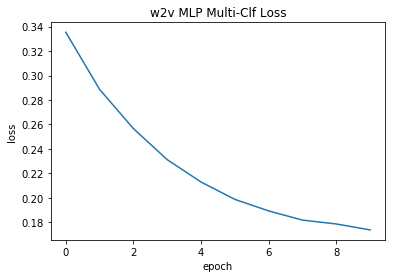

In [29]:
plt.plot(loss)
plt.title('w2v MLP Multi-Clf Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('w2vMLPMultiLoss.png')
plt.show()

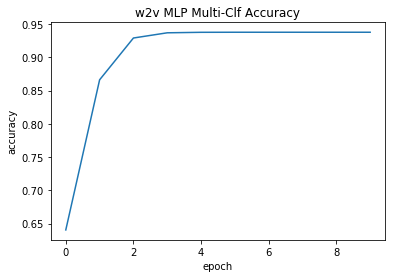

In [30]:
plt.plot(acc)
plt.title('w2v MLP Multi-Clf Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('w2vMLPMultiAcc.png')
plt.show()

In [31]:
y_hat = MLP.predict(test_X_tensor)
test['agree']=y_hat[:,0]
test['disagree']=y_hat[:,1]
test['discuss']=y_hat[:,2]

test.to_csv('w2vMLPMulti.csv',index=False)

In [34]:
def get_class_label(scores):
    if scores[0] > scores[1] and scores[0] > scores[2]:
        label='agree'
    elif scores[1] > scores[0] and scores[1] > scores[2]:
        label='disagree'
    else:
        label='discuss'
    return label

In [37]:
y_hat_df = pd.DataFrame(y_hat)
print(y_hat_df)
labels = y_hat_df.apply(get_class_label,axis=1)
print(labels)

             0             1         2
0     0.754700  2.762967e-01  0.040253
1     0.754700  2.762967e-01  0.040253
2     0.754700  2.762967e-01  0.040253
3     0.754700  2.762967e-01  0.040253
4     0.754700  2.762967e-01  0.040253
5     0.754700  2.762967e-01  0.040253
6     0.754700  2.762967e-01  0.040253
7     0.754700  2.762967e-01  0.040253
8     0.576572  1.384087e-08  0.000010
9     0.572129  1.384937e-08  0.000010
10    0.754700  2.762967e-01  0.040253
11    0.581202  1.447788e-08  0.000010
12    0.579196  1.361654e-08  0.000010
13    0.580439  1.401709e-08  0.000010
14    0.575149  1.313465e-08  0.000010
15    0.575770  1.359329e-08  0.000010
16    0.578665  1.316696e-08  0.000010
17    0.575320  1.384546e-08  0.000010
18    0.754700  2.762967e-01  0.040253
19    0.577359  1.354531e-08  0.000010
20    0.577629  1.375310e-08  0.000010
21    0.583313  1.352979e-08  0.000010
22    0.579142  1.312929e-08  0.000010
23    0.572689  1.380180e-08  0.000010
24    0.754700  2.762967e

In [40]:
confusion_matrix(test['Stance'],labels)
accuracy_score(test['Stance'],labels)

0.26637069922308548

In [32]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, accuracy_score

In [34]:
tpr, fpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr,tpr)

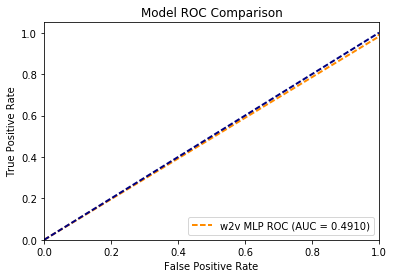

In [35]:
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='w2v MLP ROC (AUC = %0.4f)' % roc_auc,
         linestyle='--')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC Comparison')
plt.legend(loc="lower right")
plt.savefig('w2vMLPROC.png')
plt.show()

In [37]:
for cut in _:
    labels = y_hat > cut
    labels = [int(i) for i in labels]
    print(cut, accuracy_score(y_test,labels))

1.24994 0.731498956988
0.249944 0.731498956988
4.8515e-25 0.280421178107
4.8067e-25 0.280321843648
4.38639e-25 0.279427833515
4.38121e-25 0.279328499056
4.07387e-25 0.27555378961
4.04957e-25 0.27545445515
3.95246e-25 0.273666434886
3.93976e-25 0.273567100427
6.3863e-26 0.268600377471


In [38]:
labels = y_hat > 1.24994
labels = [int(i) for i in labels]
test['w2vMLP'] = labels
test.to_csv('w2vMLPBinary.csv', index=False)